# Image Compression Model

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Load and Preprocess Dataset

In [2]:
import os

# List the files and directories in the unzipped dataset
dataset_path = '/kaggle/input/celeba-dataset'
print(os.listdir(dataset_path))

['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']


In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Path to the directory containing images
image_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

# Load images
image_size = (128, 128)
images = []
for img_name in os.listdir(image_dir)[:25000]:  # Limit to 10,000 images for memory management
    img_path = os.path.join(image_dir, img_name)
    if os.path.isfile(img_path):  # Check if the path is a file
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)

images = np.array(images)

SPLIT THE MODEL

In [4]:
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

Build AutoEncoder Model

In [5]:
def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    return models.Model(inputs, encoded, name='encoder')

In [6]:
def build_decoder(encoded_shape):
    encoded_input = tf.keras.Input(shape=encoded_shape)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(encoded_input, decoded, name='decoder')

MODEL SUMMARY

In [7]:
input_shape = (128, 128, 3)  # For 128x128 images with 3 channels (RGB)
encoder = build_encoder(input_shape)
decoder = build_decoder(encoder.output_shape[1:])

autoencoder = models.Model(encoder.input, decoder(encoder.output))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │     1,550,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,101,443 (11.83 MB)

 Trainable params: 3,101,443 (11.83 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL

In [8]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50


I0000 00:00:1725367131.592250     161 service.cc:145] XLA service 0x7f8c94089a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725367131.592339     161 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725367131.592346     161 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-09-03 12:39:00.712228: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[64,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0}, f32[3,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-03 12:39:00.883231: E external/local_xla

  1/313 ━━━━━━━━━━━━━━━━━━━━ 2:03:28 24s/step - loss: 0.0961

I0000 00:00:1725367152.503382     161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - loss: 0.0303 - val_loss: 0.0062
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/50
313/313 ━━━━━━━━━━

In [9]:
autoencoder.save('autoencoder.h5')

PLOT THE TRAIN_LOSS AND VAL_LOSS

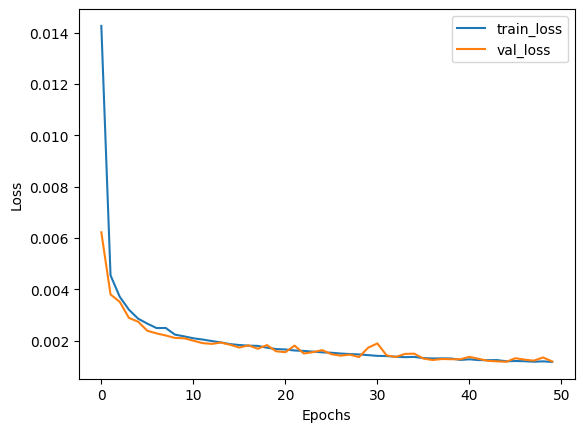

In [10]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

VISUALIZE THE RESULT

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


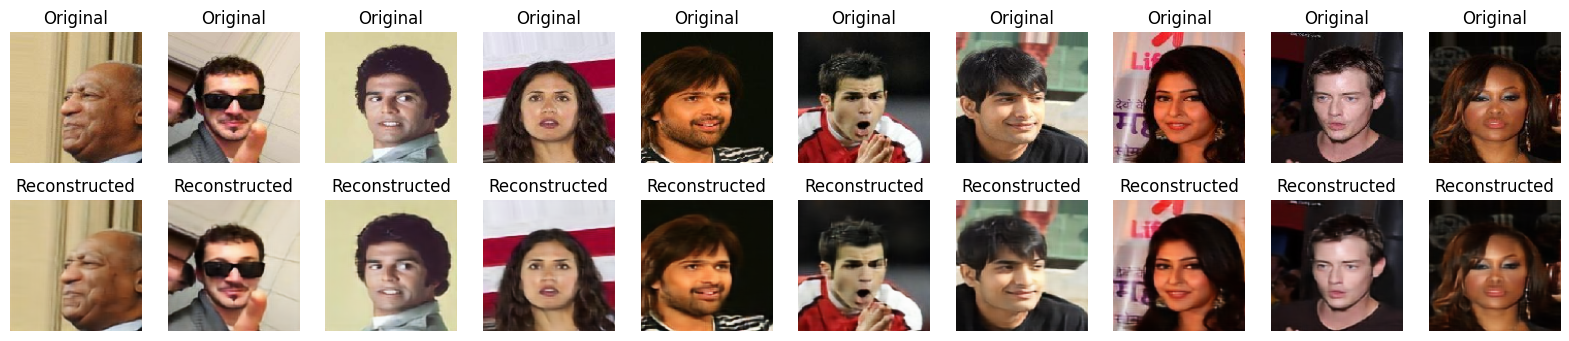

In [11]:
def display_reconstructions(model, n=10):
    idxs = np.random.randint(0, len(X_test), n)
    test_imgs = X_test[idxs]
    reconstructed_imgs = model.predict(test_imgs)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_imgs[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

display_reconstructions(autoencoder)

COMPUTE THE PERFORMANCE PARAMETER

In [12]:
import tensorflow as tf

def compute_mse(original, reconstructed):
    return tf.reduce_mean(tf.square(original - reconstructed))

def compute_psnr(original, reconstructed):
    mse = compute_mse(original, reconstructed)
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)
    return psnr

In [13]:
reconstructed_imgs = autoencoder.predict(X_test)

mse_list = []
psnr_list = []

for i in range(len(X_test)):
    mse = compute_mse(X_test[i], reconstructed_imgs[i])
    psnr = compute_psnr(X_test[i], reconstructed_imgs[i])
    mse_list.append(mse.numpy())
    psnr_list.append(psnr.numpy())

avg_mse = np.mean(mse_list)
avg_psnr = np.mean(psnr_list)

print(f"Average MSE: {avg_mse}")
print(f"Average PSNR: {avg_psnr} dB")

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Average MSE: 0.001191154238767922
Average PSNR: 29.901718139648438 dB


In [15]:
def compute_compression_ratio(input_shape, encoded_shape):
    input_size = np.prod(input_shape)
    encoded_size = np.prod(encoded_shape)
    compression_ratio = input_size / encoded_size
    return compression_ratio

input_shape = X_test[0].shape
encoded_shape = encoder.output_shape[1:]  # Exclude batch size

compression_ratio = compute_compression_ratio(input_shape, encoded_shape)
print(f"Compression Ratio: {compression_ratio:.2f}")

Compression Ratio: 0.38


In [16]:
# Evaluate PSNR, MSE, and Compression Ratio
reconstructed_imgs = autoencoder.predict(X_test)

mse_list = []
psnr_list = []

for i in range(len(X_test)):
    mse = compute_mse(X_test[i], reconstructed_imgs[i])
    psnr = compute_psnr(X_test[i], reconstructed_imgs[i])
    mse_list.append(mse.numpy())
    psnr_list.append(psnr.numpy())

avg_mse = np.mean(mse_list)
avg_psnr = np.mean(psnr_list)

input_shape = X_test[0].shape
encoded_shape = encoder.output_shape[1:]
compression_ratio = compute_compression_ratio(input_shape, encoded_shape)

print(f"Average MSE: {avg_mse}")
print(f"Average PSNR: {avg_psnr} dB")
print(f"Compression Ratio: {compression_ratio:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Average MSE: 0.001191154238767922
Average PSNR: 29.901718139648438 dB
Compression Ratio: 0.38


In [17]:
# Load and preprocess the custom image
custom_image_path = '/kaggle/input/custom-128x128-image/128X128_image.jpeg'

# Load the custom image and resize it to the model's input size
image_size = (128, 128)  # Update this if your model was trained on a different size
custom_image = load_img(custom_image_path, target_size=image_size)
custom_image = img_to_array(custom_image) / 255.0  # Normalize to [0, 1]
custom_image = np.expand_dims(custom_image, axis=0)  # Add batch dimension

In [18]:
# Compress and reconstruct the image using the full AutoEncoder
decoded_img = autoencoder.predict(custom_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


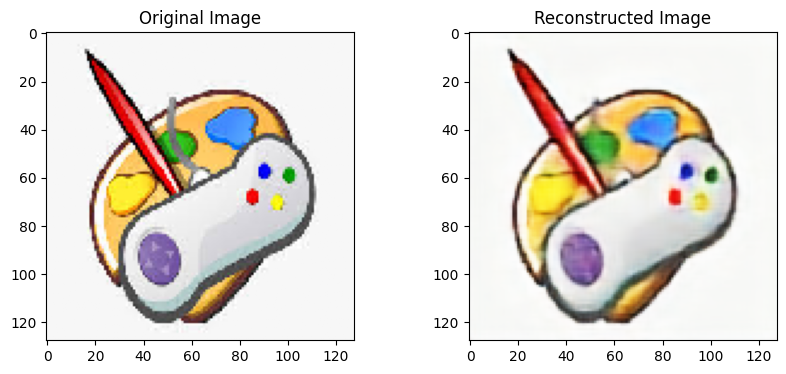

In [19]:
decoded_img = np.squeeze(decoded_img, axis=0)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(custom_image[0])
plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(decoded_img)
plt.show()

In [20]:
import tensorflow as tf

def calculate_psnr(original, reconstructed):
    return tf.image.psnr(original, reconstructed, max_val=1.0)

psnr_value = calculate_psnr(custom_image, decoded_img)
print(f'PSNR: {psnr_value.numpy()} dB')
def calculate_mse(original, reconstructed):
    return tf.reduce_mean(tf.square(original - reconstructed))

mse_value = calculate_mse(custom_image, decoded_img)
print(f'MSE: {mse_value.numpy()}')

original_size = np.prod(custom_image.shape)  # Size of the original image
encoded_size = np.prod(decoded_img.shape)  # Size of the encoded image

compression_ratio = original_size / encoded_size
print(f'Compression Ratio (CR): {compression_ratio}')



PSNR: [22.630733] dB
MSE: 0.005456655751913786
Compression Ratio (CR): 1.0
